# Example 2: How to Preserve Statistical Patterns Between Columns (PrivBayes)
In this notebook we show how a more sophisticated algorithm for generating synthetic data is able to capture patterns between columns.

# Environment

## Library Imports

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys

## Jupyter-specific Imports and Settings

In [5]:
# set printing options
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')
from importlib import reload

## Import Synthesizer
For this example we will use the PrivBayes algorithm (Zhang et al, 2017). PrivBayes approximates the original data through a private Bayesian network with noisy conditional distributions.

In [14]:
from synthesis.synthesizers import PrivBayes

# Synthetic Data Generation
Let's load a dataset to see how the generation process works.

In this example we again use the adult dataset - source: https://archive.ics.uci.edu/ml/datasets/adult

In [7]:
df_original = pd.read_csv('../data/original/adult.csv')
df_original.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Unfortunately the PrivBayes algorithm does not support continuous data very well (especially when using differential privacy), as the conditional probability tables can become very large. We can either discretize continuous variables or remove them from the data. For sake of simplicity we choose to remove them.

In [8]:
print('column - number of unique values')
df_original.nunique()

column - number of unique values


age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
income                2
dtype: int64

In [9]:
df_original = df_original.drop(columns=['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'age', 'native-country'])

We will now import our synthesizer and fit it on the input data. 

In [17]:
epsilon = 1

pb = PrivBayes(epsilon=epsilon, verbose=False)
pb.fit(df_original)

After fitting the Bayesian Network on the data, we can now sample from it using the following method.

In [22]:
df_synthetic = pb.sample()

In [23]:
df_synthetic.head()

,workclass,education,education-num,marital-status,occupation,relationship,race,sex,income
0,Private,Bachelors,13,Divorced,Tech-support,Not-in-family,Black,Female,>50K
1,Private,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,>50K
2,?,Some-college,14,Separated,?,Other-relative,Amer-Indian-Eskimo,Female,<=50K
3,Private,Some-college,10,Never-married,Exec-managerial,Other-relative,White,Male,<=50K
4,Private,HS-grad,9,Never-married,Transport-moving,Other-relative,White,Male,<=50K


# Evaluation
We can see that the synthetic data has a similar structure the original. We can also evaluate whether it has retained the statistical distributions of the original data. We use the SyntheticDataEvaluator class to compare the synthetic data to the original by applying various metrics.

In [24]:
from synthesis.evaluation import SyntheticDataEvaluator

In [25]:
evaluator = SyntheticDataEvaluator()
evaluator.fit(df_original, df_synthetic)
evaluator.score()

{'average_js_distance': 0.03228034125465419,
 'pairwise_correlation_distance': 0.4642468481349942}

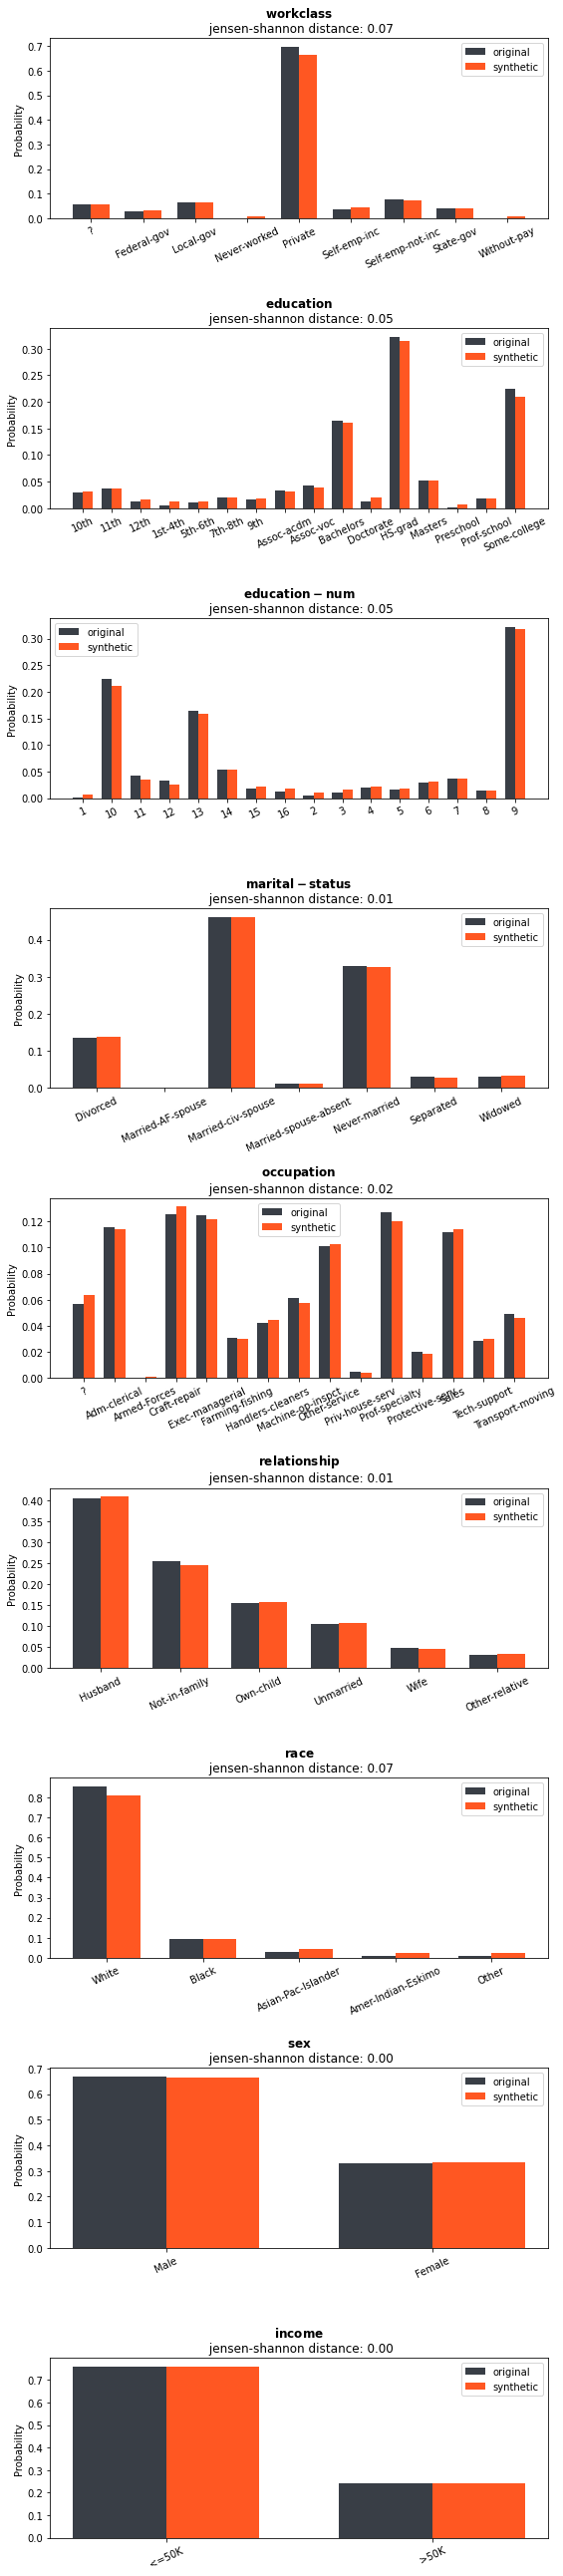

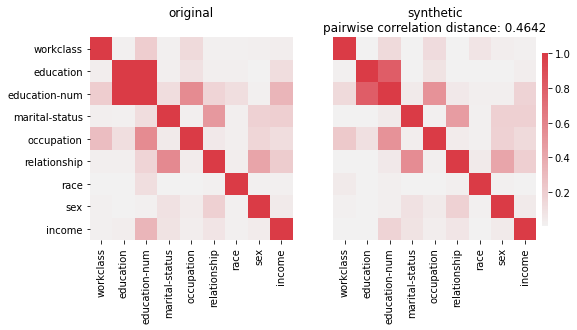

In [26]:
evaluator.plot()

We can see that not only the  marginal distributions are preserved quite well, but also the correlations in the synthetic data seem quite close to the original.

# Conclusion

In this notebook we showed how a more sophiscated algorithm like PrivBayes is able to generate synthetic data that also mimics the correlations of the original data.

However, we should note that we reduced the dimensionality considerably by removing columns with many unique values. In a future notebook we show how we can generate more complex datasets with varying column types (e.g. continuous, dates, and categorical).